# Modelado Predictivo/ *Predictive Modeling*

En este notebook continuaremos utilizando el dataset de ventas de autos para probar diversas técnicas de procesamiento de datos para modelos de ML. En concreto, además de los pasos usuales de imputación de datos faltantes, estandarización y datos atípicos, abordaremos el feature engineering, las técnicas de selección de features y los distintos ensamblados de modelos de ML.

*In this notebook, we will continue using the car sales dataset to test various data processing techniques for ML models. Specifically, in addition to the usual steps of imputing missing data, standardization, and handling outliers, we will tackle feature engineering, feature selection techniques, and different ML model ensembling strategies.*

# Librerías/ *Libraries*

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("car_prices.csv")

# Preprocesamiento/ *Preprocessing*

En este capítulo abordaremos diversos pasos del preprocesamiento: imputación de datos faltantes, transformación de tipos de datos, eliminación de columnas innecesarias, etc.

*In this chapter, we will address various preprocessing steps: imputation of missing data, transformation of data types, removal of unnecessary columns, etc.*

In [3]:
df.columns

Index(['year', 'make', 'model', 'trim', 'body', 'transmission', 'vin', 'state',
       'condition', 'odometer', 'color', 'interior', 'seller', 'mmr',
       'sellingprice', 'saledate'],
      dtype='object')

In [4]:
df1 = df.copy()

In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


Tenemos más de medio millon de registros de autos vendidos en el periodo que va de enero del 2014 a junio del 2015.

*We have over half a million records of cars sold in the period from January 2014 to June 2015.*

Eliminamos posibles registros duplicados:

*We remove any possible duplicate records:*

In [6]:
df1 = df1.drop_duplicates()

## Transformacion de tipos de datos/ *Data Type Transformation*

In [7]:
df1['saledate'] = pd.to_datetime(df1['saledate'], errors='coerce', utc=True)

## Manipulación de variables/ *Variable Manipulation*

In [8]:
#we rename the odometer column
df1.rename(columns={'odometer' : 'kms'}, inplace=True)

La columna "mmr" es el precio del Manheim Market Report y tiene una alta correlación con la variable dependiente. Esto se debe a que contienen prácticamente la misma información y no a que exista una relación lineal real.
El resto de las variables las eliminamos porque consideramos con datos que guardan poca relevancia a la hora de predecir el precio final del auto.

*The "mmr" column represents the Manheim Market Report price and has a high correlation with the dependent variable. This is because they contain essentially the same information, not because there is a real linear relationship.*

*We are removing the rest of the variables because we believe they hold little relevance in predicting the final price of the car based on our data analysis.*

In [9]:
#We removed columns with unnecessary or redundant data.
df1.drop(columns=['mmr','vin','trim','model','body', 'interior'], inplace=True)

## Imputación de datos faltantes/ *Imputation of Missing Data*

In [10]:
df1.isna().sum()

year                0
make            10301
transmission    65352
state               0
condition       11820
kms                94
color             749
seller              0
sellingprice       12
saledate           38
dtype: int64

Si bien observamos muchos datos faltantes en algunas columnas, estos representan en el peor de los casos alrededor del 2% del total de registros. Es por esto que me animaré a imputarlos con diversas estrategias.

*Although we observe many missing data points in some columns, these represent at most around 2% of the total records. Therefore, I will proceed with imputing them using various strategies.*

### Imputacion con la moda/ *Imputation using the mode*

In [11]:

# Define the subset of columns to impute
columns_to_impute = ['make', 'color']
mode_imputer_cols = df1[columns_to_impute]

# Create a SimpleImputer object with the chosen strategy (most frequent)
imputer = SimpleImputer(strategy='most_frequent')

# Fit the imputer to the subset of columns
imputer.fit(mode_imputer_cols)

# Impute missing values in the subset of columns
mode_imputer_cols_imputed = pd.DataFrame(imputer.transform(mode_imputer_cols), columns=columns_to_impute)

# Update the original DataFrame df1 with the imputed values
df1[columns_to_impute] = mode_imputer_cols_imputed


### Imputacion con la mediana/ *Imputation using the median*

Imputamos las variables númericas con la mediana para evitar que los valores extremos metan ruido en nuestros datos.

*We impute numeric variables with the median to avoid noise from extreme values in our data.*

In [12]:
# Define the subset of columns to impute
columns_to_impute = ['condition', 'kms']
median_imputer_cols = df1[columns_to_impute]

# Create a SimpleImputer object with the chosen strategy (most frequent)
imputer = SimpleImputer(strategy='median')

# Fit the imputer to the subset of columns
imputer.fit(median_imputer_cols)

# Impute missing values in the subset of columns
median_imputer_cols_imputed = pd.DataFrame(imputer.transform(median_imputer_cols), columns=columns_to_impute)

# Update the original DataFrame df1 with the imputed values
df1[columns_to_impute] = median_imputer_cols_imputed


### imputacion manual/ *manual imputation*

In [13]:
df1 = df1[~df1['transmission'].isin(["Sedan", "sedan"])]
df1 = df1.dropna()
#We check that the imputation has been successfully completed.
df1.isna().sum()

year            0
make            0
transmission    0
state           0
condition       0
kms             0
color           0
seller          0
sellingprice    0
saledate        0
dtype: int64

# Feature engineering

### Variable "year"

Eliminamos los registros de autos fabricados en 2014 y 2015.

*We remove the records of cars manufactured in 2014 and 2015.*

In [14]:
# Create a mask where True indicates the years we want to drop
dropyears = df1['year'].isin(['2014', '2015'])

# Use the inverted mask to select rows where 'year' is not '2014' or '2015'
df1 = df1[~dropyears]

### Variable "condition"

Rodendeamos los valores de la columna "condition" para que resulten en una calificación de 5 números.

*Rounded values in the "condition" column to result in a 5-point rating.*

In [15]:

df1['condition'] = (np.round(df1['condition'] / 10) * 10)


In [16]:
#Transform the rounded values into a sequence from 0 to 5.
df1['condition'] = df1['condition'] // 10


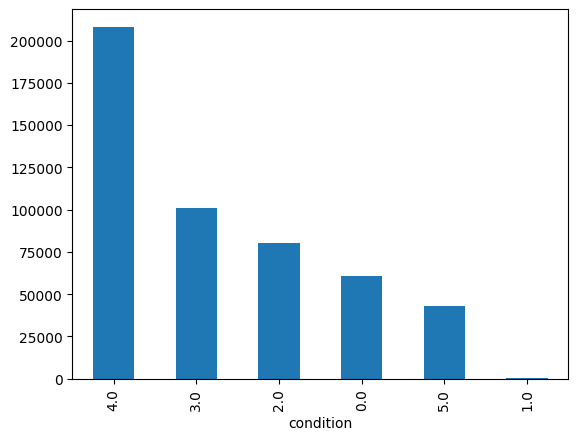

In [17]:
df1['condition'].value_counts().plot(kind='bar')
plt.show()

### Variable "datesale"

Vamos a recrear esta columna de manera que separe los datos de forma trimestral:

*We are going to recreate this column by splitting the data into quarters (trimesters).*

In [18]:
#Step 1: Normalize the dates to remove the hour, minutes, and seconds.
df1['saledate'] = df1['saledate'].dt.normalize()

# Step 2: Group by semester. Assuming 'saledate' is already normalized:
# Create an auxiliary column to define the semesters
df1['trimestre'] = df1['saledate'].dt.month.map({
    1: 'Ene-Mar', 2: 'Ene-Mar', 3: 'Ene-Mar',
    4: 'Abr-Jun', 5: 'Abr-Jun', 6: 'Abr-Jun',
    7: 'Jul-Sep', 8: 'Jul-Sep', 9: 'Jul-Sep',
    10: 'Oct-Dic', 11: 'Oct-Dic', 12: 'Oct-Dic'
})

# Now you can count how many events occurred in each semester.
result = df1.groupby('trimestre').size()

df1.columns

Index(['year', 'make', 'transmission', 'state', 'condition', 'kms', 'color',
       'seller', 'sellingprice', 'saledate', 'trimestre'],
      dtype='object')

In [19]:
df1 = df1.drop(columns=['saledate'])

### Variable "State"

Agruparemos los distintos estados en las cuatro grandes regiones del mapa de EEUU.

*We will group the different states into the four major regions of the U.S. map.*

In [20]:


# We define the mapping of states to their corresponding regions.
state_to_region = {
    'ca': 'west', 'wa': 'west', 'or': 'west', 'hi': 'west', 'ak': 'west', 'nv': 'west', 'ut': 'west', 'az': 'west', 'id': 'west', 'mt': 'west', 'wy': 'west', 'co': 'west', 'nm': 'west',
    'nd': 'midwest', 'sd': 'midwest', 'ne': 'midwest', 'ks': 'midwest', 'mn': 'midwest', 'ia': 'midwest', 'mo': 'midwest', 'wi': 'midwest', 'il': 'midwest', 'mi': 'midwest', 'in': 'midwest', 'oh': 'midwest',
    'pa': 'northeast', 'ny': 'northeast', 'nj': 'northeast', 'ct': 'northeast', 'ri': 'northeast', 'ma': 'northeast', 'vt': 'northeast', 'nh': 'northeast', 'me': 'northeast',
    'tx': 'south', 'ok': 'south', 'ar': 'south', 'la': 'south', 'ms': 'south', 'al': 'south', 'tn': 'south', 'ky': 'south', 'wv': 'south', 'md': 'south', 'de': 'south', 'va': 'south', 'nc': 'south', 'sc': 'south', 'ga': 'south', 'fl': 'south', 'pr': 'south'
}

# We apply the mapping to transform the state abbreviations into the corresponding regions.
df1['state'] = df1['state'].map(state_to_region)

df1['state'].value_counts()


state
south        223877
west         108052
midwest      100742
northeast     60777
Name: count, dtype: int64

# Estandarización/ *Standardization*

## Estandarizacion de datos numericos/ *numeric data standarization*

In [21]:
#Let's keep numeric columns
col = ['condition', 'kms', 'year']

In [22]:
scaler = MinMaxScaler()
scaler = scaler.fit(df1[col])
df1[col] = scaler.transform(df1[col])

## Codificación de datos categóricos/ *Categorical Data Encoding*

### Variables binarias/ *Binary Variables*

La única variable binaria es la que refiere a la transmisión.

*The only binary variable is the one referring to the transmission.*

In [23]:
df1['transmission'].replace({'automatic': 0,'manual': 1,},inplace=True)

### Variables dummies

Esta estrategia consiste en crear una columna binaria (que solo puede contener los valores 0 o 1) para cada valor único que exista en la variable categórica que estamos codificando, y marcar con un 1 la columna correspondiente al valor presente en cada registro, dejando las demás columnas con un valor de 0.

*This strategy involves creating a binary column (which can only contain values of 0 or 1) for each unique value in the categorical variable we are encoding. We mark the column corresponding to the value present in each record with a 1, while leaving the other columns with a value of 0.*

Vemos que -con excepción de "State"- muchas de las variables que quisieramos convertir a variables ficticias contienen demasiados valores unicos. Esto redundaria en una alta dimensionalidad, por lo tanto, las eliminaremos.

*We see that - except for "State" - many of the variables we would like to convert into dummy variables contain too many unique values. This would result in high dimensionality, so we will remove them.*

In [24]:
print(f"número de valores en la columna 'color':{len(df1['color'].unique())}")
print(f"número de valores en la columna 'make':{len(df1['make'].unique())}")
print(f"número de valores en la columna 'state':{len(df1['state'].unique())}")
print(f"número de valores en la columna 'seller':{len(df1['seller'].unique())}")

número de valores en la columna 'color':20
número de valores en la columna 'make':95
número de valores en la columna 'state':4
número de valores en la columna 'seller':13257


## Eliminación de variables catégoricas con demasiados valores/ *Removal of categorical variables with too many unique values*

In [25]:
df1 = df1.drop(columns=["color","make","seller"])

## Codificación sobre columnas modificadas/ *Encoding on modified columns*

A partir de la modificación de los valores de la columna "state", crearemos una variable dummie -a modo de experimento- con la intención de brindar a los algoritmos de ML un conjunto de variables de interés. Soy conciente que esta manipulación sobre la columna mentada puede traer ruido y nada más; veremos más adelante como responde.

*From the modification of the values in the "state" column, we will create a dummy variable as an experiment to provide ML algorithms with a set of relevant variables. I am aware that this manipulation of the mentioned column can introduce noise; we will see later how it responds.*

In [26]:
df1 = pd.get_dummies(df1, columns=['state'], prefix=['state'])

In [27]:
df1.columns

Index(['year', 'transmission', 'condition', 'kms', 'sellingprice', 'trimestre',
       'state_midwest', 'state_northeast', 'state_south', 'state_west'],
      dtype='object')

In [28]:
#transformamos la columna booleana en numerica
df1['state_midwest'] = df1['state_midwest'].replace({False: 0, True: 1})
df1['state_northeast'] = df1['state_northeast'].replace({False: 0, True: 1})
df1['state_south'] = df1['state_south'].replace({False: 0, True: 1})
df1['state_west'] = df1['state_west'].replace({False: 0, True: 1})


Realizamos la misma operación con la columna "trimestre":

*We perform the same operation with the "trimester" column:*

In [29]:
df1['trimestre'].unique()

array(['Oct-Dic', 'Ene-Mar', 'Jul-Sep', 'Abr-Jun'], dtype=object)

In [30]:
df1 = pd.get_dummies(df1, columns=['trimestre'], prefix=['trimestre'])

In [31]:
df1['trimestre_Abr-Jun'] = df1['trimestre_Abr-Jun'].replace({False: 0, True: 1})
df1['trimestre_Ene-Mar'] = df1['trimestre_Ene-Mar'].replace({False: 0, True: 1})
df1['trimestre_Jul-Sep'] = df1['trimestre_Jul-Sep'].replace({False: 0, True: 1})
df1['trimestre_Oct-Dic'] = df1['trimestre_Oct-Dic'].replace({False: 0, True: 1})

# Outliers

## Local Outlier Factor

Para limpiar nuestro conjunto de datos de valores extremos utilizaremos primero el método Local Outlier Factor que viene en la libreria de sklearn.
Este algoritmo funciona midiendo la densidad local de un punto en comparación con las densidades de sus vecinos.  Para cada punto en el conjunto de datos, el LOF calcula la distancia a sus k-vecinos más cercanos. El valor de k es un parámetro que debe ser definido previamente. La densidad local de un punto se estima basándose en las distancias a sus vecinos. Si un punto tiene vecinos muy cercanos, se considera que tiene una alta densidad local.

*To clean our dataset of outliers, we will first use the Local Outlier Factor (LOF) method available in the sklearn library.*

*This algorithm works by measuring the local density of a point relative to the densities of its neighbors. For each point in the dataset, LOF calculates the distance to its k nearest neighbors. The value of k is a parameter that must be defined beforehand. The local density of a point is estimated based on the distances to its neighbors. If a point has very close neighbors, it is considered to have a high local density.*

In [32]:
from sklearn.neighbors import LocalOutlierFactor
num_cols = df1[['condition','kms','year']]

# Instantiate LOF
lof_outlier = LocalOutlierFactor(n_neighbors=5)

# Fit and predict outliers
outlier_scores = lof_outlier.fit_predict(num_cols)

# Add outlier scores as a new column in df1
df1['LOF_outlier_scores'] = outlier_scores


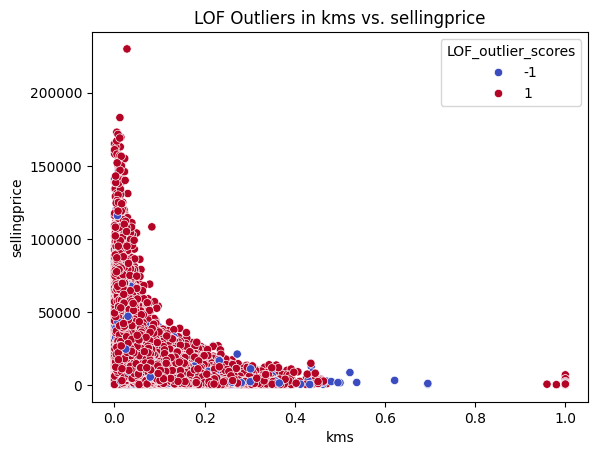

In [33]:
sns.scatterplot(df1,x="kms", y="sellingprice", hue="LOF_outlier_scores", palette="coolwarm")
plt.title("LOF Outliers in kms vs. sellingprice")
plt.show()

In [34]:
#number of outliers detected
sum(outlier_scores == -1)

24532

In [35]:
#we drop the outliers
mask = outlier_scores != -1
dfLOF = df1.loc[mask,:]

In [36]:
dfLOF = dfLOF.drop(columns=['LOF_outlier_scores'])

## Isolation Forest

El segundo metodo para detectar datos atípicos será Isolation Forest.

*The second method for detecting outliers will be Isolation Forest.*

In [37]:
from sklearn.ensemble import IsolationForest

num_cols = df1[['condition','kms','year']]
# Instantiate IF
if_outlier = IsolationForest(contamination=0.05)

# Fit and predict outliers
outlier_scores = if_outlier.fit_predict(num_cols)

# Add outlier scores as a new column in df1
df1['if_outliers_scores'] = outlier_scores

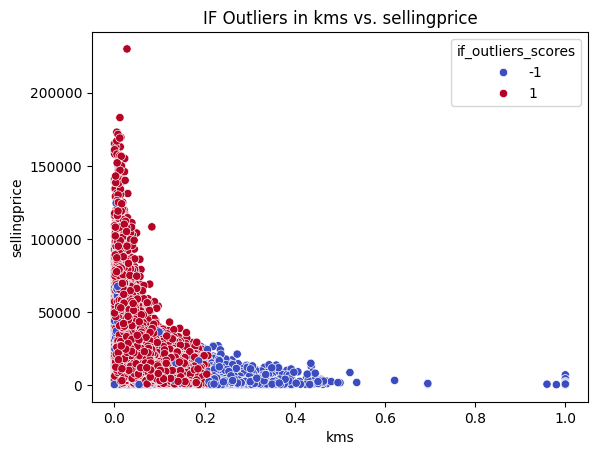

In [38]:
sns.scatterplot(df1,x="kms", y="sellingprice", hue="if_outliers_scores", palette="coolwarm")
plt.title("IF Outliers in kms vs. sellingprice")
plt.show()

In [39]:
sum(outlier_scores == -1)

24673

Más allá de lo que aparenta el gráfico más arriba, lo cierto es que ambos métodos detectan una cantidad similar de datos atípicos.

*Despite what the above graph may suggest, the truth is that both methods detect a similar number of outliers.*

In [40]:
mask = outlier_scores != -1
dfIF = df1.loc[mask,:]

In [41]:
dfIF = dfIF.drop(columns=['if_outliers_scores'])

# Problema de la distribución de datos/ *Issue with Data Distribution*

Para mejorar el rendimiento de nuestros ensambles de modelos, realizaremos algunas transformaciones sobre nuestros datos, ya que, a pesar de la eliminación de los datos atípicos, vemos distribuciones de datos muy alejadas de la campana de gausse. Es por esto que realizaremos una transformación logaritmica.

*To improve the performance of our model ensembles, we will perform some transformations on our data. Despite removing outliers, we still observe data distributions that are far from being normally distributed. Therefore, we will apply a logarithmic transformation to the data.*



## Histogramas/ *Histograms*

## *Original DF*

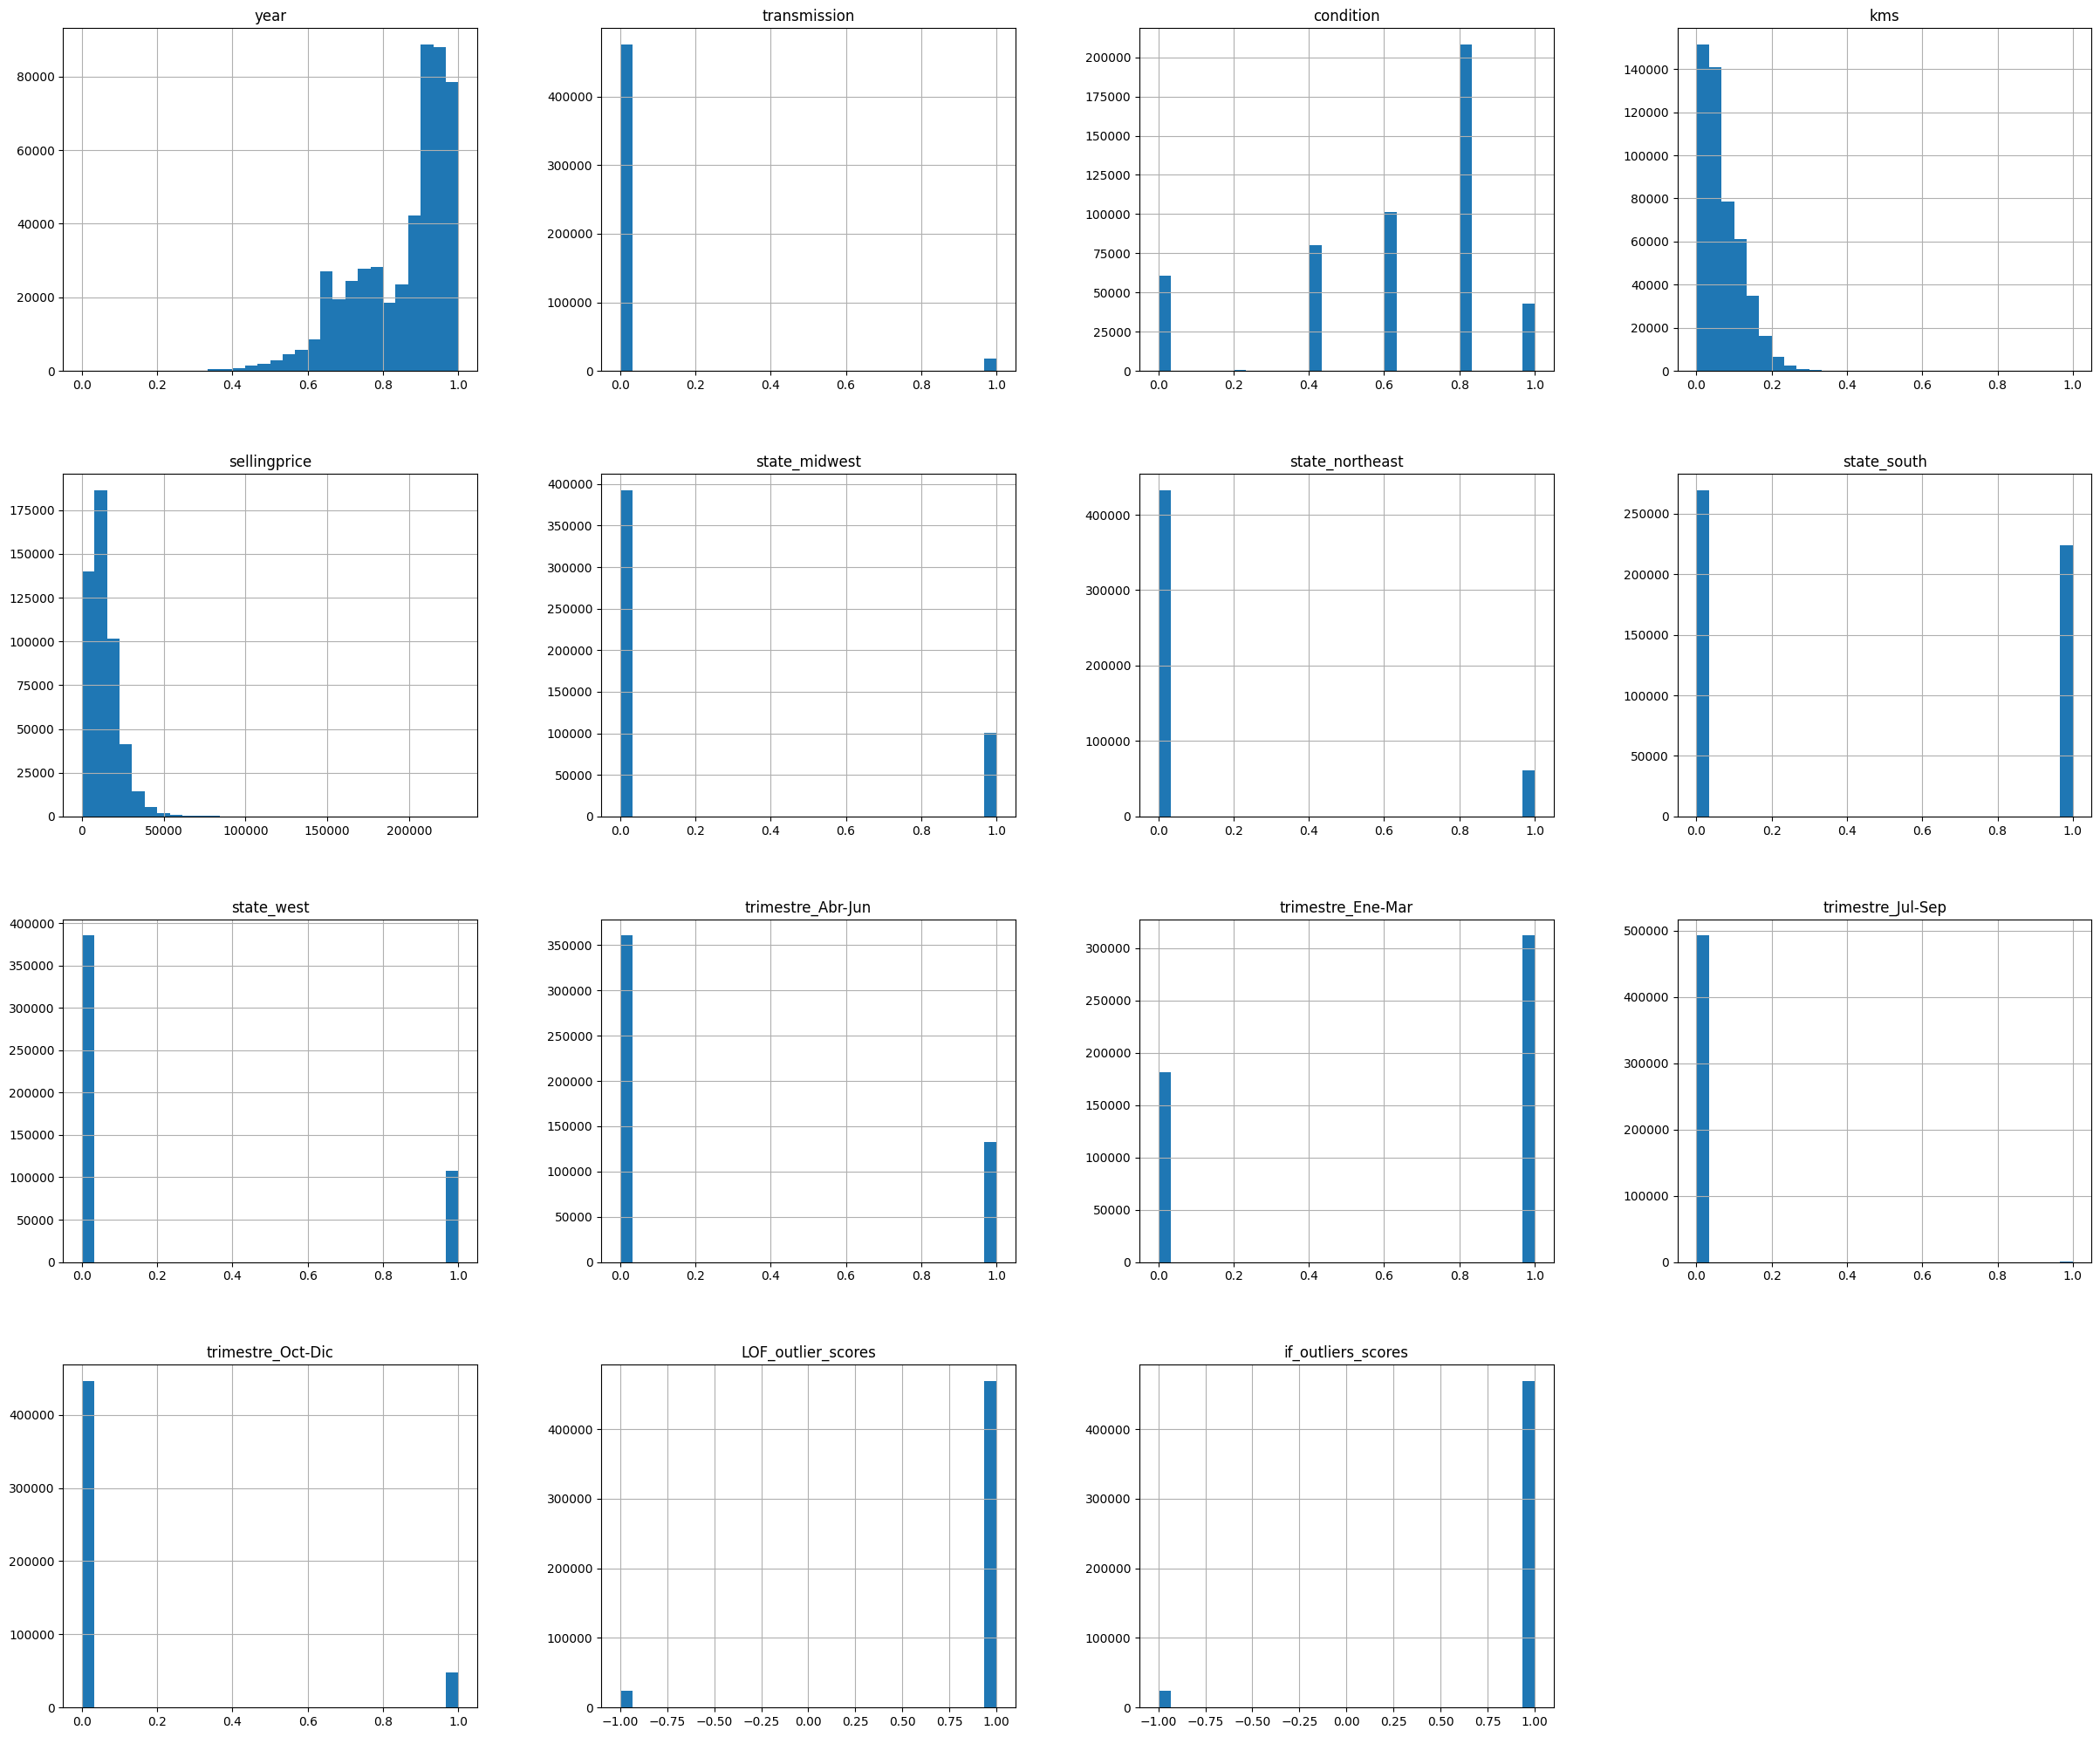

In [42]:
df1.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

## *LOF_DF*

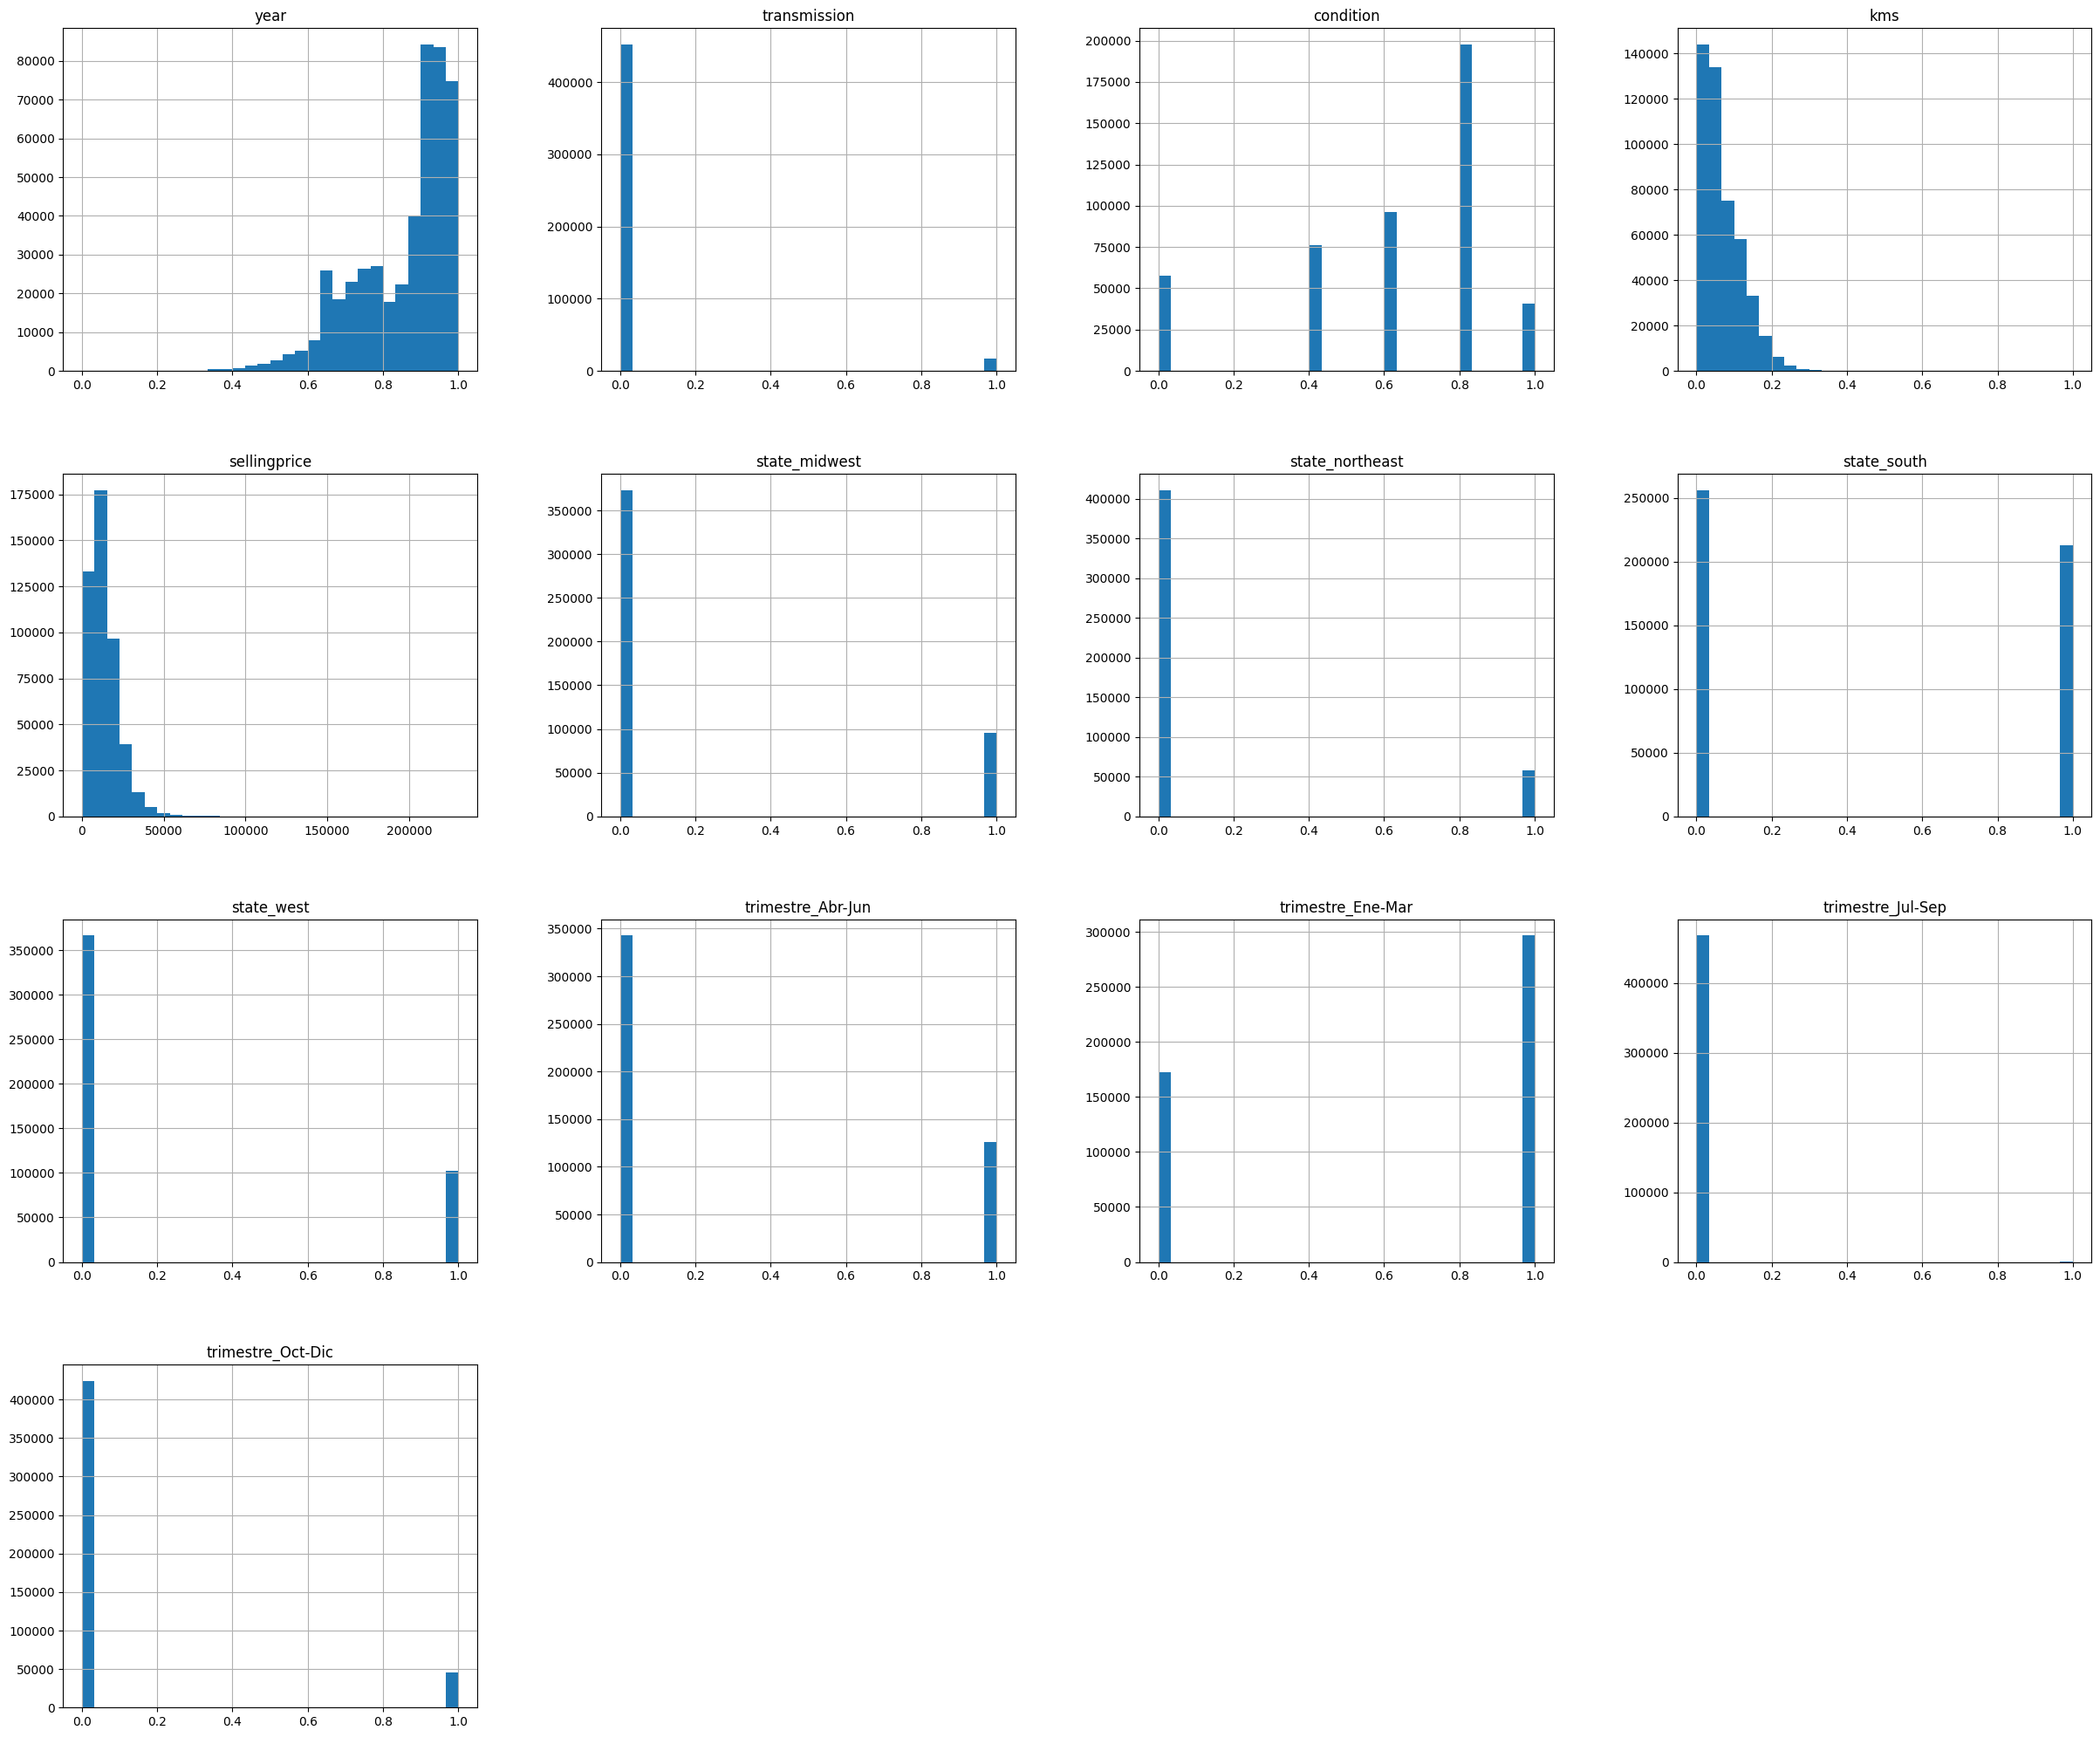

In [43]:
dfLOF.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

## *IF_DF*

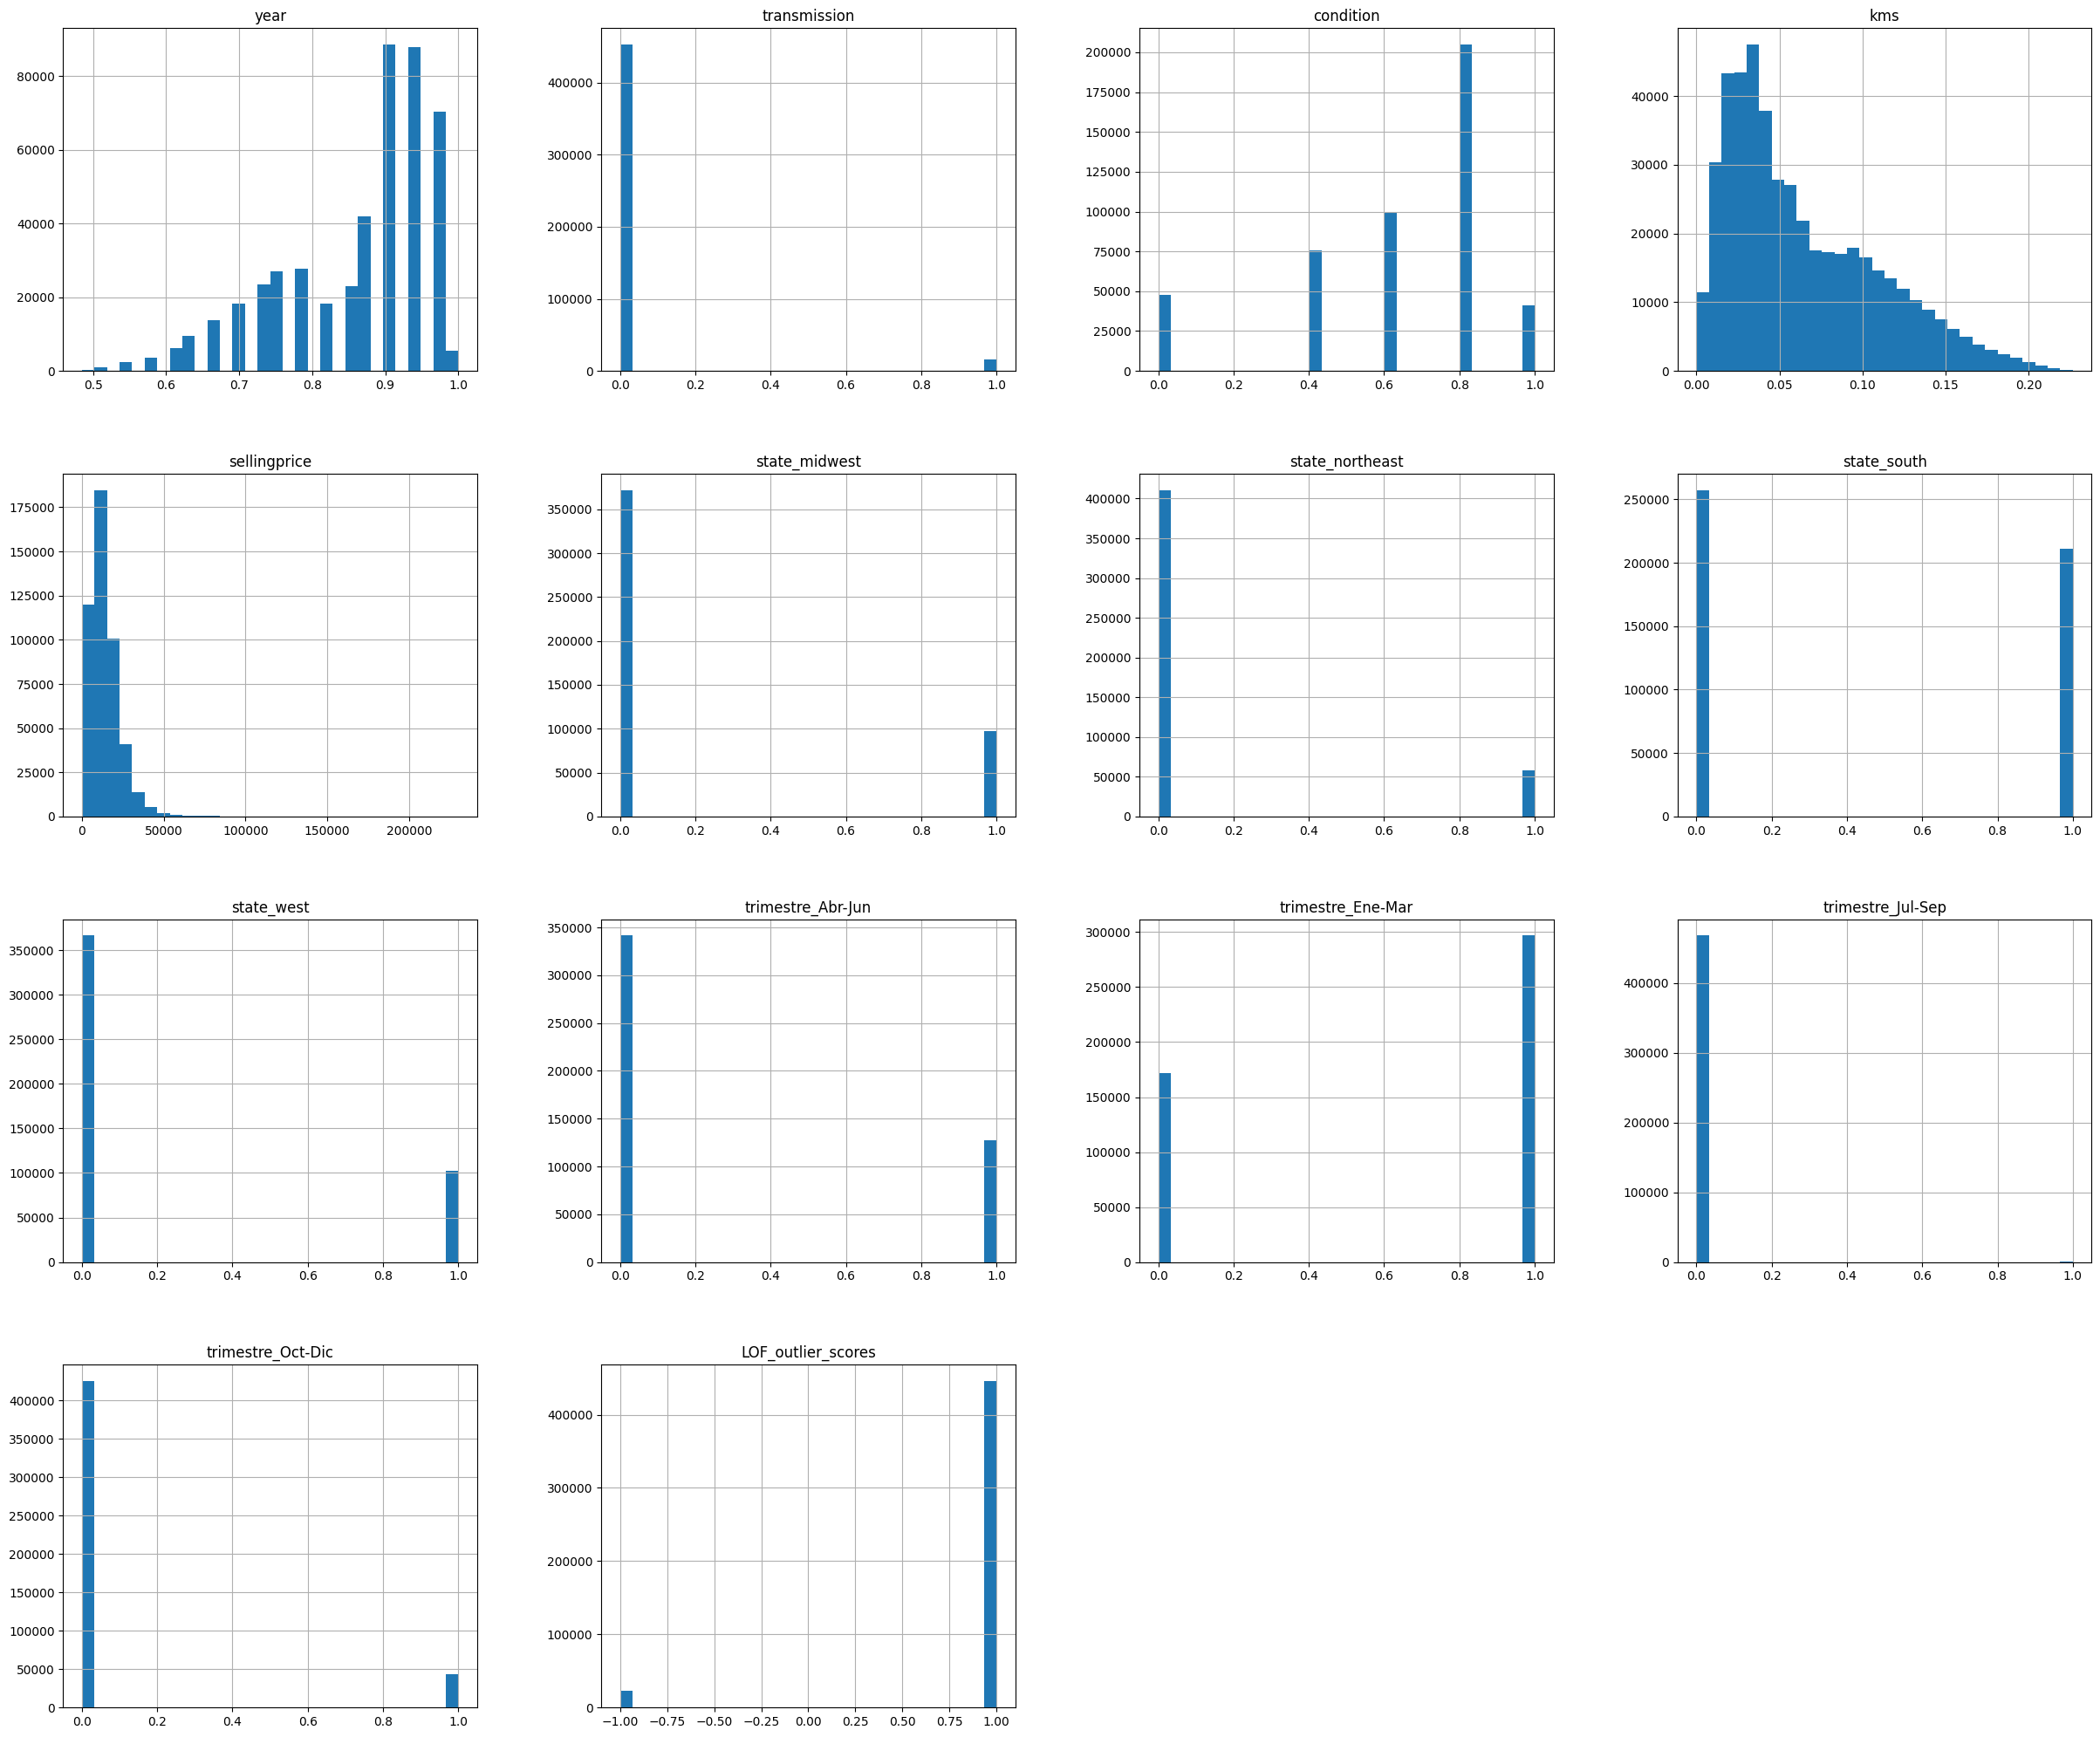

In [44]:
dfIF.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

## Transformación de variables hacia una distribución normal

In [45]:
dfLOF["sellingprice"] = np.log1p(dfLOF["sellingprice"])

In [46]:
# fix skewness  of them with 'log1p' function

col = ['condition', 'kms', 'year']

for c in dfLOF[col]:
    dfLOF[c] = np.log1p(dfLOF[c])

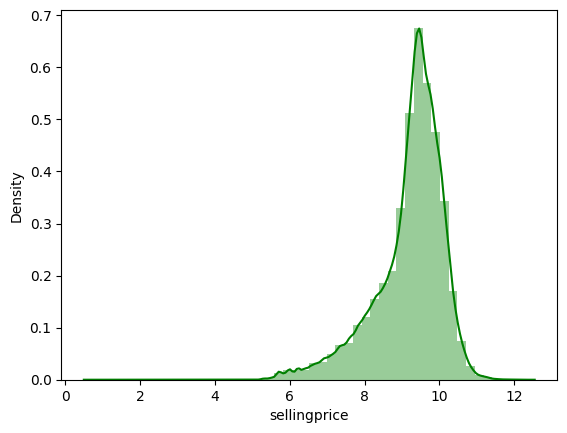

In [47]:
sns.distplot(dfLOF["sellingprice"], color = "green");

In [48]:
dfLOF.describe()

,year,transmission,condition,kms,sellingprice,state_midwest,state_northeast,state_south,state_west,trimestre_Abr-Jun,trimestre_Ene-Mar,trimestre_Jul-Sep,trimestre_Oct-Dic
count,468916.000000,468916.000000,468916.000000,468916.000000,468916.000000,468916.000000,468916.000000,468916.000000,468916.000000,468916.000000,468916.000000,468916.000000,468916.000000
mean,0.612537,0.035539,0.459489,0.065233,9.196612,0.204152,0.123105,0.453881,0.218862,0.269155,0.632335,0.002241,0.096269
std,0.067683,0.185139,0.200412,0.047882,0.915170,0.403081,0.328558,0.497869,0.413475,0.443521,0.482170,0.047290,0.294960
min,0.000000,0.000000,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.563935,0.000000,0.336472,0.028364,8.824825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.646627,0.000000,0.587787,0.051774,9.392745,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.662376,0.000000,0.587787,0.094954,9.798183,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,0.693147,1.000000,0.693147,0.693147,12.345839,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


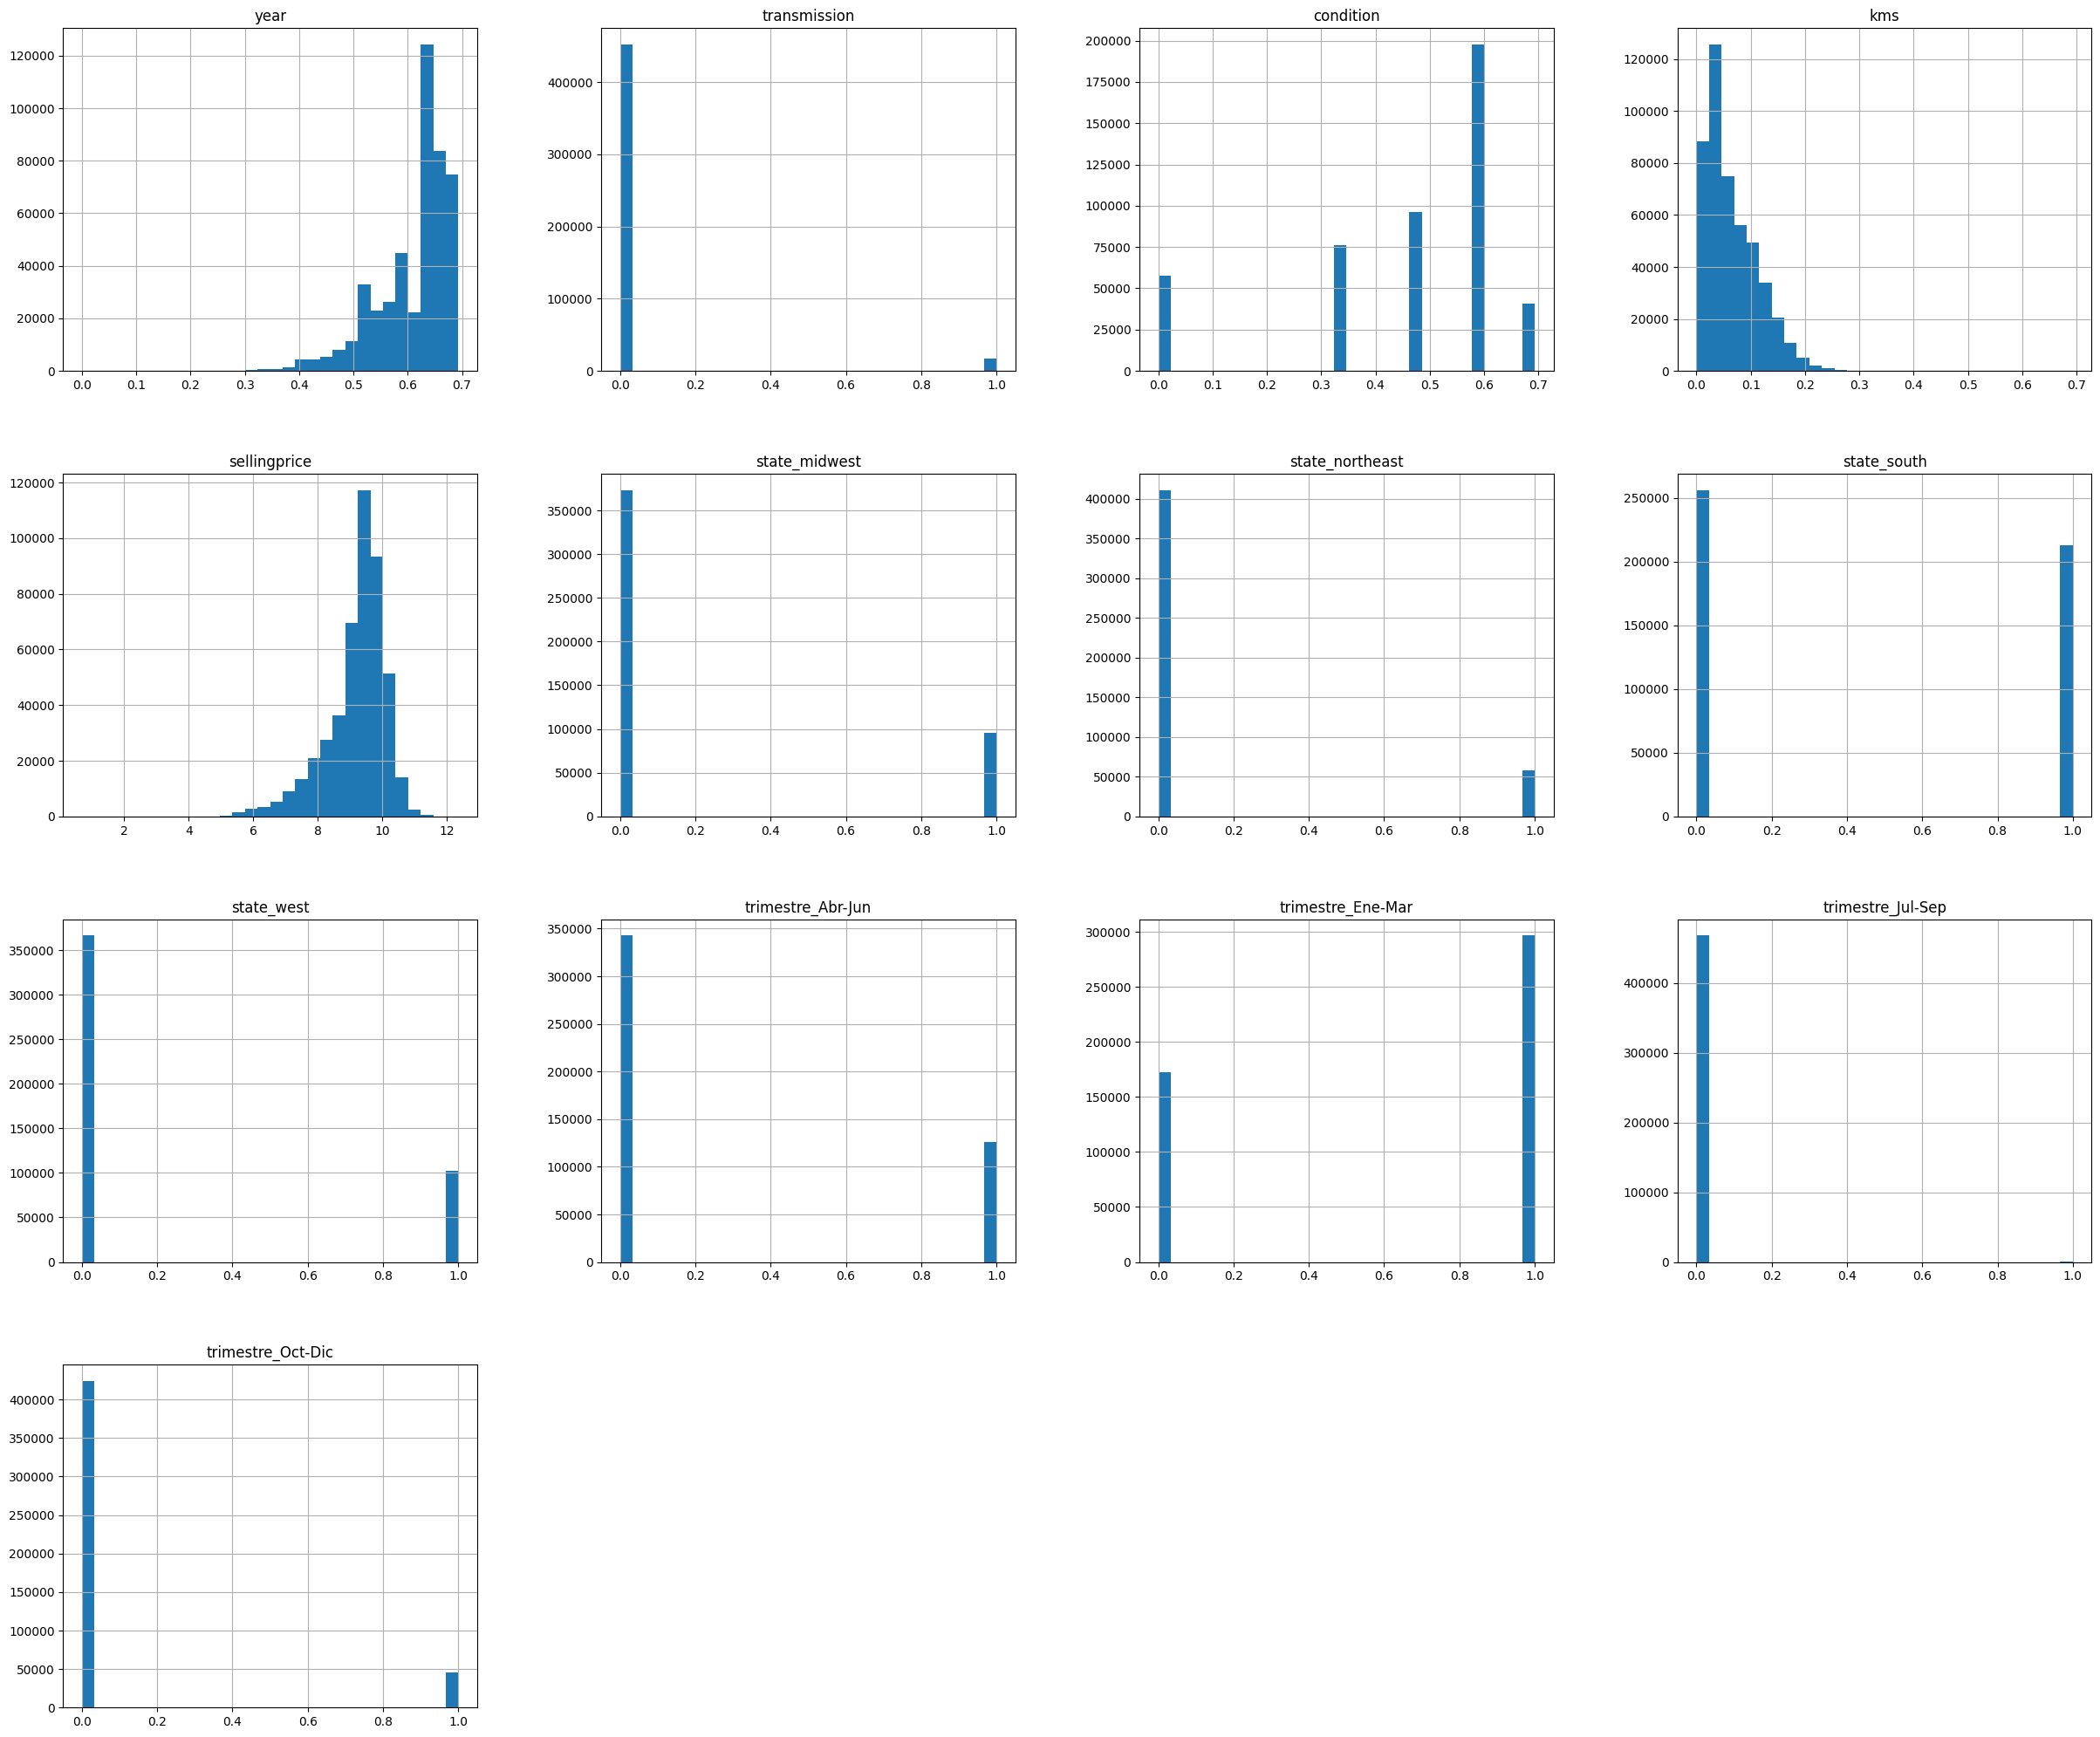

In [49]:
dfLOF.hist(figsize = (30, 25), bins = 30, legend = False)
plt.show()

# Técnicas de selección de características

Existen diversas técnicas de selección de características. Estas se dividen entre métodos de filtro y métodos de envoltura.

*There are various feature selection techniques. These are divided into filter methods and wrapper methods.*

## Train-test split

Separaremos nuestras variables X e y, con el objeto de aplicar estos métodos para analizar los coeficientes de las variables independientes.

*We will separate our variables into X and y in order to apply these methods to analyze the coefficients of the independent variables.*

In [50]:
y = dfLOF['sellingprice']
X = dfLOF.drop(columns=["sellingprice"])

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

## Métodos de filtro/ *Filter methods*

Los métodos de filtro para la selección de características en machine learning son técnicas que evalúan la importancia o relevancia de cada característica de forma independiente utilizando medidas estadísticas o heurísticas.

*Filter methods for feature selection in machine learning are techniques that assess the importance or relevance of each feature independently using statistical or heuristic measures.*


### Regularización Lasso con CV

 La regularización Lasso, también conocida como "L1 regularization", es una técnica utilizada en el aprendizaje automático y la estadística para penalizar los coeficientes de los modelos lineales, como la regresión lineal, con el objetivo de evitar el sobreajuste y realizar la selección de características.

En Lasso, se agrega una penalización a la función de pérdida del modelo, que es proporcional a la suma de los valores absolutos de los coeficientes de las características. Esta penalización impulsa a muchos coeficientes hacia cero, lo que conduce a la selección automática de características, ya que las características con coeficientes cercanos a cero se eliminan del modelo.

*Lasso regularization, also known as "L1 regularization," is a technique used in machine learning and statistics to penalize the coefficients of linear models, such as linear regression, with the goal of preventing overfitting and performing feature selection.*

*In Lasso, a penalty is added to the model's loss function that is proportional to the sum of the absolute values of the feature coefficients. This penalty drives many coefficients towards zero, which leads to automatic feature selection as features with coefficients close to zero are removed from the model.*

In [52]:
#Modelo Lasso con CV
array_alphas = np.arange(0.01, 1, 0.01)
reg_lassoCV = LassoCV(alphas=array_alphas, cv=5)
reg_lassoCV.fit(X_train, y_train)

LassoCV(alphas=array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
        cv=5)

In [53]:
# Predicciones en el conjunto de testeo para Lasso
y_pred_lassoCV = reg_lassoCV.predict(X_test)

# Cálculo del error cuadrático medio en el conjunto de testeo
mse_reg_lassoCV = mean_squared_error(y_test, y_pred_lassoCV)

#calculo del R2
R2_Lasso = r2_score(y_test,y_pred_lassoCV)

#sacamos los coeficientes
coeficientes = reg_lassoCV.coef_

print("Mejor alpha encontrado:", reg_lassoCV.alpha_)
print("Error cuadrático medio (LassoCV):", mse_reg_lassoCV)
print("R2 (LassoCV):", R2_Lasso)

Mejor alpha encontrado: 0.01
Error cuadrático medio (LassoCV): 0.32397436856208217
R2 (LassoCV): 0.6136528542182416


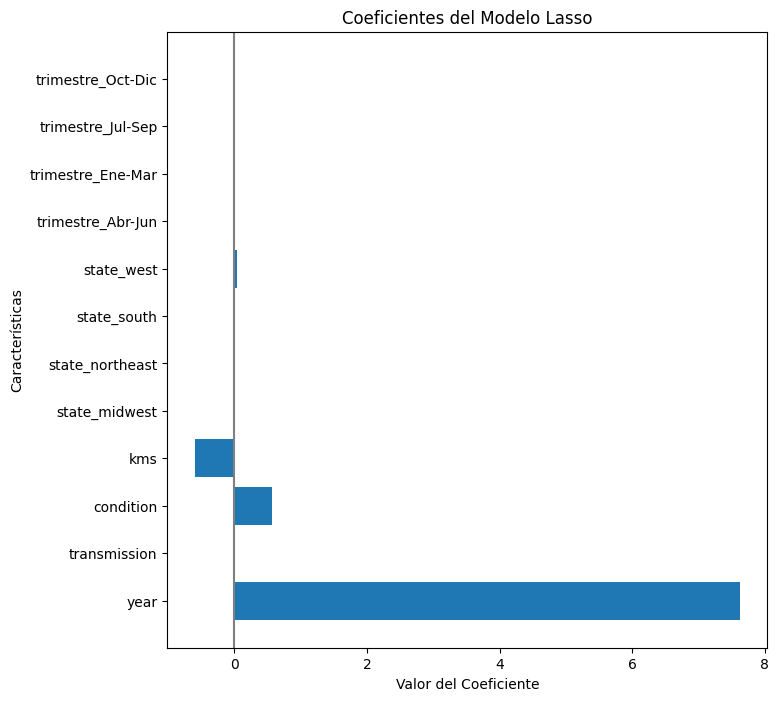

In [54]:

# De lo contrario, puedes generar una lista basada en el número de coeficientes
nombres_caracteristicas = [f'{columns}' for columns in X.columns]

# Crear el gráfico
plt.figure(figsize=(10, 8))  # Ajustar el tamaño del gráfico según sea necesario
plt.barh(nombres_caracteristicas, coeficientes)  # Crear un gráfico de barras horizontales
plt.xlabel('Valor del Coeficiente')  # Etiqueta del eje x
plt.ylabel('Características')  # Etiqueta del eje y
plt.title('Coeficientes del Modelo Lasso')  # Título del gráfico
plt.axvline(x=0, color='.5')  # Dibujar una línea vertical en x=0 para referencia
plt.subplots_adjust(left=.3)  # Ajustar si es necesario para evitar recortar nombres de características

# Mostrar el gráfico
plt.show()

Observamos como la variable "year" tiene preponderancia a la hora de interactuar y responder a la variable dependiente.

*We observe that the "year" variable plays a significant role in interacting with and responding to the dependent variable.*

### Arboles de decision/ *Decision tree*

In [55]:

# max depth in 3
tree = DecisionTreeRegressor(max_depth = 3, random_state = 42)

# train
tree.fit(X_train, y_train)

#  Score
score_in_train = tree.score(X_train, y_train)

# Score in test
score_in_test = tree.score(X_test, y_test)

print('Score en el set de entrenamiento: {}'.format(score_in_train))
print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de entrenamiento: 0.6371053925892882
Score en el set de testeo: 0.6376450829603073


### Decision tree with regularization

In [56]:
for i in range(2, 8, 1):

    # Creamos el modelo para un dado valor de i
    arbol = DecisionTreeRegressor(max_depth = i, random_state = 42)

    # Calculamos los scores al hacer cross-validation con 5 folds
    scores = cross_val_score(arbol, X_train, y_train, cv = 5)

    # Imprimimos el valor de alpha y el score medio
    print(f'profundidad {i} - Score medio = {scores.mean()}')

profundidad 2 - Score medio = 0.5918967909716518
profundidad 3 - Score medio = 0.6366032059161371
profundidad 4 - Score medio = 0.6667961744653319
profundidad 5 - Score medio = 0.6821724110060945
profundidad 6 - Score medio = 0.6927216331328575
profundidad 7 - Score medio = 0.7005486326338202


In [57]:
arbol_prof7 = DecisionTreeRegressor(max_depth = 7, random_state = 42)

# Entrenamiento
arbol_prof7.fit(X_train, y_train)

# Score en el set de testeo
score_in_test_arbol = arbol_prof7.score(X_test, y_test)

print(f'Score en el set de testeo: {score_in_test_arbol}')

Score en el set de testeo: 0.7003323025925872


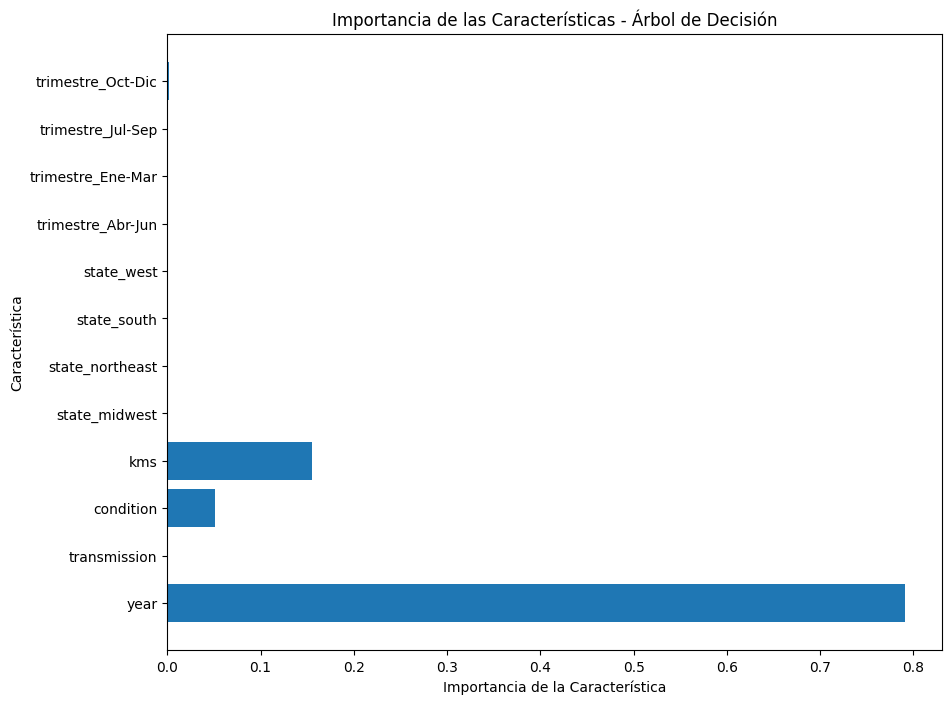

In [58]:
# Obtener la importancia de las características
importancias = arbol_prof7.feature_importances_

# Nombres de las características para este conjunto de datos
nombres_caracteristicas = X.columns

# Crear un gráfico para visualizar la importancia de las características
plt.figure(figsize=(10, 8))
plt.barh(range(len(importancias)), importancias, align='center')
plt.yticks(np.arange(len(nombres_caracteristicas)), nombres_caracteristicas)
plt.xlabel('Importancia de la Característica')
plt.ylabel('Característica')
plt.title('Importancia de las Características - Árbol de Decisión')
plt.show()

En el analisis del arbol de decision las incidencias se exacerban: observamos casi la misma preponderancia de las variables pero de manera más acentuada.

*In the analysis of the decision tree, the impacts are exacerbated: we observe nearly the same significance of the variables but in a more pronounced manner.*

### Varianza superior a umbral/ *Variance above threshold*

Un enfoque sencillo de selección de características es aquel que selecciona solo las características cuya varianza supera un cierto umbral. La idea detrás de este enfoque es que, si la varianza de una variable es pequeña, las probabilidades de que el valor contenido en ella sea el mismo -o muy parecido- son elevadas, por lo que aportará poco al algoritmo.

*A simple approach to feature selection is one that selects only the features whose variance exceeds a certain threshold. The idea behind this approach is that if a variable has low variance, the likelihood that the values contained within it are the same or very similar is high, indicating that it contributes little to the algorithm.*

In [59]:
X.var(ddof = 0).sort_values(ascending = False)

state_south          0.247873
trimestre_Ene-Mar    0.232487
trimestre_Abr-Jun    0.196711
state_west           0.170962
state_midwest        0.162474
state_northeast      0.107950
trimestre_Oct-Dic    0.087001
condition            0.040165
transmission         0.034276
year                 0.004581
kms                  0.002293
trimestre_Jul-Sep    0.002236
dtype: float64

In [60]:
from sklearn.feature_selection import VarianceThreshold

In [61]:
selector = VarianceThreshold(threshold = 0.2)

In [62]:
X_umbral = selector.fit_transform(X)
X_umbral

array([[0., 0.],
       [0., 0.],
       [0., 1.],
       ...,
       [0., 0.],
       [1., 0.],
       [0., 0.]])

Podemos ver las características seleccionadas son el siguiente código:

*We can see the selected features with the following code:*



In [63]:
X.columns[selector.get_support()]

Index(['state_south', 'trimestre_Ene-Mar'], dtype='object')

y los nombres de las características no seleccionadas con el siguiente código:

*And the names of the unselected features:*



In [64]:
X.columns[~selector.get_support()]

Index(['year', 'transmission', 'condition', 'kms', 'state_midwest',
       'state_northeast', 'state_west', 'trimestre_Abr-Jun',
       'trimestre_Jul-Sep', 'trimestre_Oct-Dic'],
      dtype='object')

In [65]:
selector.variances_

array([0.00458096, 0.03427636, 0.04016488, 0.00229269, 0.16247379,
       0.10795031, 0.24787303, 0.17096155, 0.1967105 , 0.23248745,
       0.00223632, 0.08700115])

In [66]:

varianzas = selector.variances_

nombres_caracteristicas = X.columns

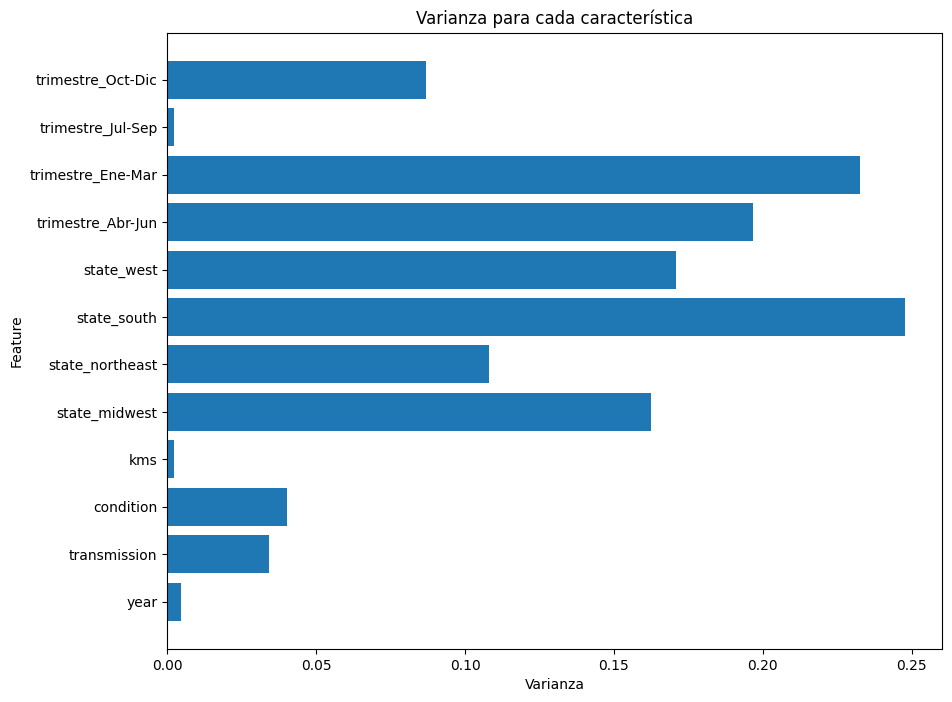

In [67]:
# Crear un gráfico para visualizar la importancia de las características
plt.figure(figsize=(10, 8))
plt.barh(range(len(varianzas)), varianzas, align='center')
plt.yticks(np.arange(len(nombres_caracteristicas)), nombres_caracteristicas)
plt.xlabel('Varianza')
plt.ylabel('Feature')
plt.title('Varianza para cada característica')
plt.show()

## Metodos de envoltura/ *Wrapper Methods*

Los métodos de envoltura son computacionalmente más intensivos que los métodos de filtro porque requieren entrenar el modelo varias veces con diferentes conjuntos de características. Sin embargo, su principal ventaja es que pueden tener en cuenta las interacciones entre características y seleccionar conjuntos óptimos de características para un modelo específico.

Algunos ejemplos comunes de métodos de envoltura incluyen el algoritmo de eliminación hacia atrás (backward elimination), el algoritmo de selección hacia adelante (forward selection), y la eliminación recursiva de características (recursive feature elimination).

*Wrapper methods are computationally more intensive than filter methods because they require training the model multiple times with different feature subsets. However, their main advantage is that they can take into account interactions between features and select optimal sets of features for a specific model.*

*Some common examples of wrapper methods include backward elimination, forward selection, and recursive feature elimination. These methods are useful when aiming to maximize the predictive performance of a model by selecting the most relevant features for the problem at hand.*

### Recursive Feature Elimination

Recursive Feature Elimination (RFE) es una técnica de selección de características utilizada en aprendizaje automático para identificar las características más relevantes para un modelo predictivo. Funciona eliminando iterativamente las características menos importantes del conjunto de datos hasta que se alcanza el número deseado de características o hasta que se cumpla algún criterio de detención predefinido.

*Recursive Feature Elimination (RFE) is a feature selection technique used in machine learning to identify the most relevant features for a predictive model. It works by iteratively eliminating the least important features from the dataset until the desired number of features is reached or until a predefined stopping criterion is met.*

In [68]:
from sklearn.feature_selection import RFE

In [69]:
# Crear un modelo base
modelo_base = LinearRegression()

# Crear un selector RFE
selector = RFE(estimator=modelo_base, n_features_to_select=3, step=1)

# Aplicar el selector RFE al conjunto de datos
selector = selector.fit(X, y)

# Características seleccionadas
caracteristicas_seleccionadas = X.columns[selector.support_]

# Características eliminadas
caracteristicas_eliminadas = X.columns[~selector.support_]

print("Características seleccionadas:", caracteristicas_seleccionadas)
print("Características eliminadas:", caracteristicas_eliminadas)

Características seleccionadas: Index(['trimestre_Abr-Jun', 'trimestre_Ene-Mar', 'trimestre_Jul-Sep'], dtype='object')
Características eliminadas: Index(['year', 'transmission', 'condition', 'kms', 'state_midwest',
       'state_northeast', 'state_south', 'state_west', 'trimestre_Oct-Dic'],
      dtype='object')


### Sequential Feature Selection

Sequential Feature Selection (SFS) es otra técnica de selección de características utilizada en aprendizaje automático. A diferencia de Recursive Feature Elimination (RFE), SFS sigue un enfoque de avance, donde comienza con un conjunto vacío de características y va agregando características una a una hasta que se cumple algún criterio de detención predefinido.


Sequential Feature Selection (SFS) is another feature selection technique used in machine learning. Unlike Recursive Feature Elimination (RFE), SFS follows a forward approach where it starts with an empty set of features and adds features one by one until a predefined stopping criterion is met.

In [70]:
from sklearn.feature_selection import SequentialFeatureSelector

# Crear un modelo base
modelo_base = LinearRegression()

# Crear un selector SFS
selector = SequentialFeatureSelector(estimator=modelo_base, n_features_to_select=2, direction='forward')

# Aplicar el selector SFS al conjunto de datos
selector = selector.fit(X, y)

# Características seleccionadas
caracteristicas_seleccionadas = X.columns[selector.get_support(indices=True)]
print("Características seleccionadas:", caracteristicas_seleccionadas)


Características seleccionadas: Index(['year', 'kms'], dtype='object')


# *Feature reduction*

Teniendo en cuenta los disímiles resultados de las métodos de selección de características, he realizado la reducción dando mayor atención a los métodos de envoltura realizados al final. Como estos no han tenido las mimsmas conclusiones, la conformación de X es un híbrido entre ambos resultados.

*Considering the diverse results of the feature selection methods, I have performed the reduction by giving more attention to the wrapper methods conducted at the end. Since these methods did not yield the same conclusions, the composition of X is a hybrid between both results.*

In [72]:
# X = X.drop(columns=['transmission', 'state_midwest', 'state_northeast', 'state_west',])
y = dfLOF['sellingprice']
X = dfLOF[['year','kms', 'condition','trimestre_Abr-Jun', 'trimestre_Ene-Mar', 'trimestre_Jul-Sep']]

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Ensamblado de modelos/Ensemble Learning

La técnica de aprendizaje ensamblado consiste en combinar diferentes modelos de ML para obtener mejores predicciones que las que nos proporcionarían los diferentes modelos por separado.

*The technique of ensemble learning involves combining different ML models to obtain better predictions than what individual models would provide on their own.*

## Voting regressor

In [74]:

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor


r1 = LinearRegression()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = KNeighborsRegressor()

voting_reg = VotingRegressor([('lr', r1), ('rf', r2), ('r3', r3)])



In [75]:
voting_reg.fit(X_train, y_train)

VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf',
                             RandomForestRegressor(n_estimators=10,
                                                   random_state=1)),
                            ('r3', KNeighborsRegressor())])

In [76]:
from sklearn.metrics import r2_score

for reg in (r1, r2, r3, voting_reg):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(reg.__class__.__name__, r2_score(y_test, y_pred))

LinearRegression 0.6645826363609795
RandomForestRegressor 0.5962060770658206
KNeighborsRegressor 0.6549765091556398
VotingRegressor 0.6788736191220028


## Bagging y Pasting

Otra alternativa a la hora de aplicar aprendizaje ensamblado consiste en usar el mismo modelo, pero entrenado con diferentes subsets del dataset de entrenamiento. Si cada modelo es entrenado con un subset único, la técnica se llama pasting. En caso contrario, se llama bagging (abreviación de bootstrap aggregating), lo cual es más común y la técnica usada en los Random Forest (útil sobretodo en datasets pequeños).

*Another alternative for applying ensemble learning involves using the same model but trained on different subsets of the training dataset. If each model is trained on a unique subset, the technique is called pasting. On the other hand, if models are trained on overlapping subsets, it is called bagging (short for bootstrap aggregating), which is more common and the technique used in Random Forests (especially useful for small datasets).*

In [77]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression


# Definir y ajustar el BaggingRegressor
bag_reg = BaggingRegressor(
    base_estimator=DecisionTreeRegressor(random_state=42),  # Modelo base para regresión
    n_estimators=500,  # Número de estimadores (árboles) en el ensamble
    max_samples=100,  # Número de muestras para entrenar cada árbol
    bootstrap=True,  # Si se utilizan muestras con reemplazo
    random_state=42,  # Semilla aleatoria para reproducibilidad
    oob_score=True  # Si calcular el puntaje fuera de la bolsa (OOB)
)
bag_reg.fit(X_train, y_train)

# Realizar predicciones
y_pred = bag_reg.predict(X_test)


In [78]:
print(r2_score(y_test, y_pred))

0.6919252892939399


### Random Forest (bagging)

Un Random Forest no es más que un ensamblado de árboles de decisión entrenados usando la técnica de bagging. En Scikit-Learn, puedes usar el modelo RandomForestRegressor directamente.

*A Random Forest is indeed an ensemble of decision trees trained using the bagging technique. In Scikit-Learn, you can use the RandomForestRegressor model directly to apply Random Forest for regression tasks.*

In [79]:
from sklearn.ensemble import RandomForestRegressor

r_forest = RandomForestRegressor(n_estimators=500, max_leaf_nodes=16, random_state=42)
r_forest.fit(X_train, y_train)




RandomForestRegressor(max_leaf_nodes=16, n_estimators=500, random_state=42)

In [80]:
# Score en el set de testeo
score_in_test = r_forest.score(X_test, y_test)
print('Score en el set de testeo: {}'.format(score_in_test))

Score en el set de testeo: 0.6713284726512225


In [81]:
 y_pred_rf = r_forest.predict(X_test)
 print(r2_score(y_test, y_pred_rf))

0.6713284726512225


In [82]:
print(f'columnas de X: {X.columns}')
print(f'Importancia en Bosque aleatorio: {r_forest.feature_importances_}')

columnas de X: Index(['year', 'kms', 'condition', 'trimestre_Abr-Jun', 'trimestre_Ene-Mar',
       'trimestre_Jul-Sep'],
      dtype='object')
Importancia en Bosque aleatorio: [0.81589314 0.14070684 0.04340002 0.         0.         0.        ]


## Boosting

La técnica de Boosting consiste en entrenar modelos de manera secuencial, cada uno intentando corregir los errores del modelos predecesor. Las técnicas de boosting más populares son AdaBoost y Gradient Boosting.

*The boosting technique involves training models sequentially, with each model attempting to correct the errors of its predecessor. The most popular boosting techniques are AdaBoost and Gradient Boosting.*

### AdaBoost

En la técnica de AdaBoost cada modelo intenta corregir a su predecesor prestando más atención a las muestras de entrenamiento a las cuales el modelo anterior hizo underfitting. Empieza entrenando un clasificador o regresor básico, el cual es utilizado para hacer predicciones en los datos de entrenamiento. Entonces, el algoritmo aumenta la importancia relativa de aquellas muestras que han sido clasificadas erróneamente. Después, se entrena un segundo modelo utilizando estos nuevos pesos y así sucesivamente. Una vez todos los modelos han sido entrenados, se hace una predicción en ensamblado de votación con la diferencia de que cada predicción lleva asociada un peso que depende de su precisión promedia en el dataset modificado. En Scikit-Learn podemos usar el objeto AdaBoostClassifier.


*In the AdaBoost technique, each model attempts to correct its predecessor by paying more attention to the training samples that were misclassified by the previous model (i.e., those where the previous model underfit). The process starts by training a basic classifier or regressor, which is used to make predictions on the training data. Then, the algorithm increases the relative importance of those samples that were classified incorrectly. Subsequently, a second model is trained using these new weights, and this process continues iteratively. Once all models have been trained, predictions are made through a weighted voting ensemble, where each prediction is associated with a weight that depends on its average accuracy on the modified dataset.*

In [83]:
from sklearn.ensemble import AdaBoostRegressor

ada_reg = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1), n_estimators=200, learning_rate=0.5, random_state=42)
ada_reg.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=1),
                  learning_rate=0.5, n_estimators=200, random_state=42)

In [ ]:
 y_pred_ada = ada_reg.predict(X_test)
 print(r2_score(y_test, y_pred_ada))

### Gradient Boosting

De la misma manera que AdaBoost, Gradient Boosting consiste en entrenar modelos de manera secuencial, cada uno corrigiendo los errores del anterior. La diferencia es que, en vez de ajustar la importancia de las muestras mal clasificadas, cada modelo se entrena con el error residual del modelo anterior.

*Similarly to AdaBoost, Gradient Boosting involves training models sequentially, with each one correcting the errors of the previous model. The difference is that, instead of adjusting the importance of misclassified samples, each model is trained using the residual error of the previous model.*

In [91]:
from sklearn.ensemble import GradientBoostingRegressor

Los modelos de Gradient Boosting son muy propensos al overfitting, por lo que usar técnicas de regularización como el early stopping para encontrar el número óptimo de árboles de decision en el modelo es aconsejable.


*Gradient Boosting models are indeed prone to overfitting, which is why using regularization techniques such as early stopping to find the optimal number of decision trees in the model is advisable.*

In [86]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_tra, X_val, y_tra, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=400, random_state=42)
gbrt.fit(X_tra, y_tra)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
print(f'mejor número de estimadores: {gbrt_best.fit(X_tra, y_tra)}')

mejor número de estimadores: GradientBoostingRegressor(max_depth=2, n_estimators=400, random_state=42)


In [90]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=400, learning_rate=1.0, random_state=42)
gbrt.fit(X_train, y_train)
y_pred_gbr = gbrt.predict(X_test)
print(r2_score(y_test, y_pred_gbr))

0.7078233873310593


Estos algoritmos son muy potentes y populares, sobretodo en competiciones en Kaggle y plataformas similares. En ellas, una implementación popular de estos algoritmos se encuentra en la librería XGBoost, diseñada y optimizada para este tipo de modelos de ML.


*These algorithms are very powerful and popular, especially in competitions on platforms like Kaggle. One popular implementation of these algorithms is found in the XGBoost library, which is designed and optimized specifically for these types of ML models.*

### XGBoost

In [ ]:
!pip install xgboost

In [92]:
import xgboost
xgb_reg = xgboost.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)
y_pred_xgboost = xgb_reg.predict(X_test)
print(r2_score(y_test, y_pred_xgboost))

0.7102508575279749


De más esta decir que esta notebook no se propone configurar modelos de alta precisión predictiva sino demostrar las distintas opciones en el amplio abanico de los temas tratados.

*Needless to say, this notebook is not intended to configure high-precision predictive models but rather to demonstrate the various options within the broad spectrum of the topics covered.*